Przed oddaniem zadania upewnij się, że wszystko działa poprawnie.
**Uruchom ponownie kernel** (z paska menu: Kernel$\rightarrow$Restart) a następnie
**wykonaj wszystkie komórki** (z paska menu: Cell$\rightarrow$Run All).

Upewnij się, że wypełniłeś wszystkie pola `TU WPISZ KOD` lub `TU WPISZ ODPOWIEDŹ`, oraz
że podałeś swoje imię i nazwisko poniżej:

In [1]:
NAME = "Weronika Pawlak"

---

# Naiwny Bayes

Model Naiwnego Bayesa jest jednym z najprostszych modeli grafowych. Zakłada on, że wszystkie obserwowane zmienne $X_1, X_2, \ldots, X_N$ są warunkowo niezależne względem zmiennej $Y$ oraz, że jedyna zależność istnieje między zmienną $Y$ a zmiennymi $\mathbf{X}$ (zobacz rysunek). 

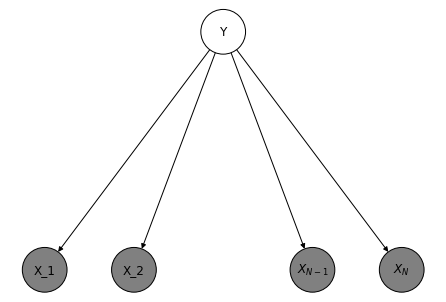

In [3]:
import networkx as nx
    
g = nx.DiGraph()
g.add_edges_from([("Y", "X_1"), ("Y", "X_2"), ("Y", "$X_{N-1}$"), ("Y", "$X_N$")])

nx.draw(
    g, 
    with_labels=True, 
    node_color=["gray" if "X" in v else "white" for v in g.nodes()],
    pos={"Y": (0, 0), "X_1": (-2, -1), "X_2": (-1, -1), "$X_{N-1}$": (1, -1), "$X_N$": (2, -1)},
    edgecolors="black",
    node_size=2000,
)

## Naiwny klasyfikator Bayesa

Naszym celem będzie rozwiązać zadanie klasyfikacji, gdzie klasa będzie reprezentowana przez zmienną $Y$ (zakładamy, że istnieje $K$ klas), natomiast atrybuty opisujące dane instancje to $X_1, X_2, \ldots, X_N$ (wartości te mogą być zarówno ciągłe, jak i dyskretne). 

Dla konkretnej instancji opisanej $x_1, x_2, \ldots, x_N$ poszukujemy jej rzeczywistej klasy $\hat y$, którą uzyskujemy maksymalizując prawdopodobieństwo warunkowe klasy $y_k$ pod warunkiem danych $x_1, x_2, \ldots, x_N$:

$$\tag{1}\hat{y} = \operatorname*{argmax}_{k \in \{1, 2, \ldots, K\}} \mathbb{P}(y_k | x_1, x_2, \ldots, x_N)$$

Wykorzystując regułę Bayesa możemy to prawdopodobieństwo rozpisać jako:

$$\mathbb{P}(y_k|x_1, x_2, \ldots, x_N) = \frac{\mathbb{P}(y_k)\mathbb{P}(x_1, x_2, \ldots, x_N | y_k)}{\mathbb{P}(x_1, x_2, \ldots, x_N)}$$

Licznik tego ułamka możemy zapisać jako prawdopodbieństwo łączne:

$$\tag{2}\mathbb{P}(y_k)\mathbb{P}(x_1, x_2, \ldots, x_N | y_k) = \mathbb{P}(y_k, x_1, x_2, \ldots, x_N)$$

Dodatkowo możemy pominąć mianownik i zapisać, że prawdopodobieństwo $\text{(1)}$ jest proporcjonalne do $\text{(2)}$:

$$\mathbb{P}(y_k|x_1, x_2, \ldots, x_N) \propto \mathbb{P}(y_k, x_1, x_2, \ldots, x_N)$$

Korzystając wielokrotnie z reguły łańcuchowej możemy dokonać faktoryzacji prawdopodobieństwa łącznego:

$$\tag{3}
\begin{align}
\mathbb{P}(y_k, x_1, x_2, \ldots, x_N) & = \mathbb{P}(x_1, x_2, \ldots, x_N, y_k)\\
& = \mathbb{P}(x_1 | x_2, \ldots, x_N, y_k)\mathbb{P}(x_2, \ldots, x_N, y_k) \\
& \ldots \\
& = \mathbb{P}(x_1 | x_2, \ldots, x_N, y_k)\mathbb{P}(x_2 | \ldots, x_N, y_k) \ldots \mathbb{P}(x_{N-1}|x_N, y_k) \mathbb{P}(x_N | y_k)\mathbb{P}(y_k)
\end{align}
$$

"Naiwność" tego modelu zakłada, że zmienne $X_1, \ldots, X_N$ są niezależne pod warunkiem $Y$, stąd:

$$\tag{4}\mathbb{P}(x_i | x_{i+1}, x_{i+2}, \ldots, x_N, y_k) = \mathbb{P}(x_i|y_k)$$

Aplikując $\text{(4)}$ do $\text{(3)}$ otrzymujemy:

$$\mathbb{P}(y_k|x_1, x_2, \ldots, x_N) \propto \mathbb{P}(y_k, x_1, x_2, \ldots, x_N) = \mathbb{P}(y_k)\mathbb{P}(x_1|y_k)\mathbb{P}(x_2|y_k)\ldots\mathbb{P}(x_N|y_k) = \mathbb{P}(y_k)\prod_{i=1}^{N}\mathbb{P}(x_i|y_k)$$

$$\mathbb{P}(y_k|x_1, x_2, \ldots, x_N) \propto \mathbb{P}(y_k)\prod_{i=1}^{N}\mathbb{P}(x_i|y_k)$$

Ostatecznie otrzymujemy:

$$\hat y = \operatorname*{argmax}_{k \in \{1, 2, \ldots, K\}} \mathbb{P}(y_k)\prod_{i=1}^{N}\mathbb{P}(x_i|y_k)$$

# Zmienne ciągłe
Będziemy się tutaj posługiwać zbiorem danych Iris, który posiada tylko ciągłe atrybuty.

In [4]:
import pandas as pd
from sklearn import datasets as sk_ds
from sklearn import model_selection as sk_ms


def load_iris_dataset():
    X, y = sk_ds.load_iris(return_X_y=True)
    X = pd.DataFrame(X, columns=[
        "sepal-length",
        "sepal-width",
        "petal-length",
        "petal-width",
    ])

    X_tr, X_te, y_tr, y_te = sk_ms.train_test_split(X, y, train_size=0.8, stratify=y)
    print("Full", X.shape, y.shape)
    print("Train", X_tr.shape, y_tr.shape)
    print("Test", X_te.shape, y_te.shape)

    return {
        "train": {"X": X_tr, "y": y_tr},
        "test": {"X": X_te, "y": y_te},
    }


iris = load_iris_dataset()

Full (150, 4) (150,)
Train (120, 4) (120,)
Test (30, 4) (30,)


In [5]:
iris["train"]["X"].head()

,sepal-length,sepal-width,petal-length,petal-width
87,6.3,2.3,4.4,1.3
16,5.4,3.9,1.3,0.4
123,6.3,2.7,4.9,1.8
137,6.4,3.1,5.5,1.8
99,5.7,2.8,4.1,1.3


In [6]:
iris["train"]["y"]

array([1, 0, 2, 2, 1, 0, 1, 0, 2, 0, 0, 1, 1, 0, 0, 0, 2, 2, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 0, 1, 0, 0, 0, 2, 2, 2, 2, 2, 1,
       0, 1, 0, 1, 2, 1, 0, 2, 0, 1, 1, 0, 2, 1, 2, 1, 2, 2, 2, 0, 1, 2,
       0, 1, 2, 2, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1,
       2, 2, 0, 2, 1, 1, 1, 0, 2, 1, 0, 1, 2, 2, 1, 0, 2, 2, 0, 1, 2, 1,
       2, 0, 2, 0, 1, 1, 1, 0, 2, 0])

### Implementacja w bibliotece `scikit-learn`
Załóżmy, że wszystkie zmienne tutaj pochodzą z rozkładu normalnego - użyjemy klasy `GaussianNB` (model naiwnego Bayesa z rozkładami normalnymi)

In [7]:
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics as sk_mtr


clf_scikit = GaussianNB()
clf_scikit.fit(X=iris["train"]["X"], y=iris["train"]["y"])

for split in ("train", "test"):
    print(split)
    print(sk_mtr.classification_report(
        y_true=iris[split]["y"],
        y_pred=clf_scikit.predict(X=iris[split]["X"]),
    ))

train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       0.93      0.93      0.93        40
           2       0.93      0.93      0.93        40

    accuracy                           0.95       120
   macro avg       0.95      0.95      0.95       120
weighted avg       0.95      0.95      0.95       120

test
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        10

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



### Implementacja w bibliotece `pyro`
Poniżej zamieszczono przykładową implementację modelu naiwnego Baysa za pomocą biblioteki Pyro. Nie będziemy wchodzić w szczegóły, ale zachęcamy aby przeanalizować krok po kroku każdą z metod.

In [8]:
import pyro
from pyro import distributions as dist
import torch
from torch.distributions import constraints

pyro.enable_validation(True)


from collections import defaultdict
import matplotlib.pyplot as plt
import pyro
import torch
from tqdm.auto import tqdm


class GaussianNBClassifier:
    def __init__(self, num_epochs=500, lr=1e-2):
        self._num_epochs = num_epochs
        self._lr = lr
        
        self._num_cls = None
        
        self._c_logits = None        
        self._num_probs = None
        
    def fit(self, X, y):
        pyro.clear_param_store()

        svi = pyro.infer.SVI(
            model=self._model,
            guide=self._guide,
            optim=pyro.optim.Adam({'lr': self._lr}),
            loss=pyro.infer.Trace_ELBO(),
        )

        with tqdm(range(self._num_epochs)) as pbar:
            for epoch in pbar:
                loss = svi.step(X, y)

                if epoch % 100 == 0:
                    print(f"Epoch: {epoch} Loss = {loss:.3f}")

    def predict(self, X):
        pred = pyro.infer.Predictive(
            model=self._model,
            guide=self._guide,
            num_samples=1,
            return_sites=('logP(c|x)',),
        )
        log_pcx = pred(X)['logP(c|x)'].detach().squeeze(0).squeeze(0)
        y_pred = torch.argmax(log_pcx, dim=-1)
        return y_pred
    
    def _model(self, X, y=None):    
        if y is not None:  # training mode
            self._num_cls = max(y) + 1
            
            numerical_cols = X.columns.values
                    
            self._init_c_logits()
            self._init_num_params(X, numerical_cols)
            self._observe_numerical_features_given_classes(X, y)

        self._observe_classes(X, y)
        
    def _guide(self, X, y=None):
        pass  # This is meant to be an empty function
    
    def _init_c_logits(self):
        self._c_logits = pyro.param(
            'c_logits',
            torch.ones(self._num_cls).div(self._num_cls),
            constraint=constraints.simplex,
        )
        
    def _init_num_params(self, X, numerical_cols):
        self._num_probs = {
            col: {
                'mu': pyro.param(f'{col}_mu', torch.zeros(self._num_cls)),
                'sigma': pyro.param(f'{col}_sigma', torch.ones(self._num_cls)),
            }
            for col in numerical_cols
        }
        
    def _observe_numerical_features_given_classes(self, X, y):
        for c in range(self._num_cls):
            x_c = X[y==c]
            with pyro.plate(f'data-numerical-{c}', x_c.shape[0]):
                for nc, v in self._num_probs.items():
                    pyro.sample(
                        f'P(x_{nc}|c={c})', 
                        dist.Normal(v['mu'][c], v['sigma'][c]),
                        obs=torch.tensor(x_c[nc].values),
                    )
                    
    def _get_log_likelihood(self, X):
        log_lk = []
        
        for c in range(self._num_cls):
            lps = []
            
            lps.extend([
                dist.Normal(v['mu'][c], v['sigma'][c]).log_prob(torch.tensor(X[nc].values))
                for nc, v in self._num_probs.items()
            ])

            log_lk.append(torch.stack(lps).sum(dim=0))
            
        return torch.stack(log_lk).t()
    
    def _observe_classes(self, X, y):
        if y is not None:
            y = torch.tensor(y)
        
        log_lk = self._get_log_likelihood(X)

        log_pcx = pyro.deterministic('logP(c|x)', self._c_logits.log() + log_lk)
        
        with pyro.plate('data-pred', X.shape[0]):    
            pyro.sample(
                'c',
                dist.Categorical(logits=log_pcx),
                obs=y,
            )

In [9]:
clf_pyro = GaussianNBClassifier(num_epochs=1000)
clf_pyro.fit(X=iris["train"]["X"], y=iris["train"]["y"])


for split in ("train", "test"):
    print(split)
    print(sk_mtr.classification_report(
        y_true=iris[split]["y"],
        y_pred=clf_pyro.predict(X=iris[split]["X"]),
    ))

Epoch: 0 Loss = 4360.764
Epoch: 100 Loss = 1505.592
Epoch: 200 Loss = 1056.422
Epoch: 300 Loss = 825.529
Epoch: 400 Loss = 669.545
Epoch: 500 Loss = 570.902
Epoch: 600 Loss = 524.511
Epoch: 700 Loss = 484.184
Epoch: 800 Loss = 443.606
Epoch: 900 Loss = 393.908

train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       0.90      0.95      0.93        40
           2       0.95      0.90      0.92        40

    accuracy                           0.95       120
   macro avg       0.95      0.95      0.95       120
weighted avg       0.95      0.95      0.95       120

test
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        10

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1

### Implementacja w bibliotece `pgmpy`

## Zadanie 1 (0.75 pkt)

Zaimplementuj funkcję `discretize_data`, która dokona dyskretyzacji (np. `KBinsDiscretizer`) zmiennych ciągłych w zadanym zbiorze danych. Zmienne kategoryczne/dyskretne nie powinny zostać zmienione. 

In [10]:
from copy import deepcopy
from sklearn.preprocessing import KBinsDiscretizer


def discretize_data(dataset: dict, n_bins: int) -> dict:
    _dataset = deepcopy(dataset)
    
    X_train = _dataset["train"]["X"]
    X_test = _dataset["test"]["X"]
    
    discrete_cols = X_train.select_dtypes('category').columns.values
    continuous_cols = [c for c in X_train.columns if c not in discrete_cols]
    est = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
    X_train[continuous_cols] = est.fit_transform(X_train[continuous_cols])
    X_test[continuous_cols] = est.transform(X_test[continuous_cols])
    _dataset["train"]["X"] = X_train
    _dataset["test"]["X"] = X_test
    # TU WPISZ KOD
    #raise NotImplementedError()
    
    return _dataset

## Zadanie 2 (0.4 pkt)

Zaimplementuj funkcję `build_model`, która zbuduje model Naiwnego Bayesa na podstawie obiektu `BayesianModel` (nie wykorzytuj klasy `NaiveBayes` z pgmpy!).

In [11]:
from pgmpy.models import BayesianModel


def build_model(dataset: dict) -> BayesianModel:
    model = BayesianModel()
    for x in list(dataset['train']['X'].columns):
        model.add_edge('y', x)
    return  model

## Zadanie 3 (0.5 pkt)

Zaimplementuj funkcję `fit_model`, która dopasuje parametry modelu Naiwnego Bayesa. Użyj dowolnej metody estymacji (np. Maximum Likelihood)

In [12]:
from pgmpy.estimators import MaximumLikelihoodEstimator
def fit_model(model: BayesianModel, training_data: dict) -> BayesianModel:
    _dataset = deepcopy(training_data['X'])
    _dataset['y'] = training_data['y']
    model.fit(_dataset, estimator=MaximumLikelihoodEstimator)
    return model

## Zadanie 4 (0.75 pkt)

Zaimplementuj funkcję `predict_pgmpy`, która zwróci predykcje modelu Naiwnego Bayesa dla zadanych danych `X`. Użyj dowolnej metody inferencji (np. Variable Elimination).

In [13]:
from pgmpy.inference import VariableElimination
def predict_pgmpy(model, X):
    ve = VariableElimination(model)
    y_pred = []
    #print(X)
    for idx, row in X.iterrows():
        query = ve.map_query(['y'], dict(row),show_progress=False)
        y_pred.append(query['y'])
    return y_pred

Wykorzystajmy teraz zaimplementowane funkcje, aby wyuczyć model Naiwnego Bayesa w pgmpy i sprawdźmy jakość działania modelu na zdyskretyzowanych danych. 

In [15]:
iris_discrete = discretize_data(dataset=iris, n_bins=5)
#print(iris_discrete["train"]['y'])
clf_pgmpy = build_model(dataset=iris_discrete)
clf_pgmpy = fit_model(model=clf_pgmpy, training_data=iris_discrete["train"])


for split in ("train", "test"):
    print(split)
    print(sk_mtr.classification_report(
        y_true=iris_discrete[split]["y"],
        y_pred=predict_pgmpy(model=clf_pgmpy, X=iris_discrete[split]["X"]),
    ))

train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       0.88      0.90      0.89        40
           2       0.90      0.88      0.89        40

    accuracy                           0.93       120
   macro avg       0.93      0.92      0.92       120
weighted avg       0.93      0.93      0.92       120

test
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.91      1.00      0.95        10
           2       1.00      0.90      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



C:\Users\User\Anaconda3\lib\site-packages\pgmpy\factors\discrete\DiscreteFactor.py:460: RuntimeWarning: invalid value encountered in true_divide
  phi.values = phi.values / phi.values.sum()


# Zmienne ciągłe i dyskretne
Wykorzystaj zbiór CMC, aby sprawdzić wszystkie modele na zbiorze z cechami dyskretnymi i ciągłymi.

In [16]:
def load_cmc(N=-1):
    # Source: https://archive.ics.uci.edu/ml/datasets/Contraceptive+Method+Choice
    df = pd.read_csv('data/cmc.data', names=[
        'age', # numerical
        'w-education', # categorical
        'h-education',  # categorical
        'num-children',  # numerical
        'w-religion',  # binary
        'w-working',  # binary
        'h-occupation',  # categorical
        'sol-index',  # categorical
        'media-exposure',  # binary
        'contraceptive-method-used',  # class
    ])

    cat_cols = [
        'w-education', # categorical
        'h-education',  # categorical
        'h-occupation',  # categorical
        'sol-index',  # categorical
    ]
    bin_cols = [
        'w-religion',  # binary
        'w-working',  # binary
        'media-exposure',  # binary
    ]

    for col in cat_cols:
        df[col] = (df[col] - 1).astype('category')

    for col in bin_cols:
        df[col] = df[col].astype('category')    

    if N != -1:
        df = df.sample(
            n=N,
            weights='contraceptive-method-used',
            random_state=2020,
        )

    X = df[df.columns[:-1]]
    y = df['contraceptive-method-used'].values - 1

    X_tr, X_te, y_tr, y_te = sk_ms.train_test_split(X, y, train_size=0.8, stratify=y)
    print('Full', X.shape, y.shape)
    print('Train', X_tr.shape, y_tr.shape)
    print('Test', X_te.shape, y_te.shape)

    return {
        'train': {'X': X_tr.reset_index(drop=True), 'y': y_tr},
        'test': {'X': X_te.reset_index(drop=True), 'y': y_te},
    }

In [17]:
cmc = load_cmc(N=200)

Full (200, 9) (200,)
Train (160, 9) (160,)
Test (40, 9) (40,)


In [18]:
cmc["train"]["X"].head()

,age,w-education,h-education,num-children,w-religion,w-working,h-occupation,sol-index,media-exposure
0,43,3,3,5,0,1,0,3,0
1,37,3,3,1,1,1,0,3,0
2,32,1,2,4,1,1,2,1,0
3,27,2,3,2,1,1,0,2,0
4,32,3,3,2,1,0,0,3,0


In [19]:
cmc["train"]["y"]

array([2, 0, 2, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 0, 2, 1, 2, 2, 2,
       1, 2, 2, 1, 2, 0, 2, 2, 0, 0, 2, 1, 0, 0, 0, 1, 2, 2, 2, 0, 1, 2,
       0, 2, 1, 1, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 1,
       2, 2, 0, 0, 2, 2, 0, 0, 1, 2, 1, 0, 2, 1, 2, 2, 2, 0, 1, 2, 2, 2,
       2, 1, 0, 2, 0, 1, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 0,
       2, 0, 2, 1, 1, 0, 2, 1, 1, 0, 2, 0, 1, 2, 2, 1, 0, 2, 2, 0, 2, 1,
       2, 2, 2, 0, 0, 1, 2, 2, 2, 0, 1, 2, 2, 1, 2, 2, 2, 1, 2, 0, 2, 1,
       2, 0, 0, 1, 0, 2], dtype=int64)

### Implementacja w `pyro`
Poprzednio użyta implementacja Naiwnego Bayesa w bibliotece Pyro nie obsługuje zmiennych dyskretnych. Poniżej zamieszczamy implementację obsługująca oba typy zmiennych. Zachęcamy do dokładniejszej analizy kodu.

In [20]:
class FullNBClassifier(GaussianNBClassifier):
    def __init__(self, num_epochs=500, lr=1e-2):
        super().__init__(num_epochs, lr)
        self._cat_probs = None
        
    # fit() from base class
    
    # predict() from base class
    
    def _model(self, X, y=None):  # Override  
        if y is not None:  # training mode
            self._num_cls = max(y) + 1
            
            categorical_cols = X.select_dtypes('category').columns.values  # Changed
            numerical_cols = [c for c in X.columns if c not in categorical_cols]  # Changed
                    
            self._init_c_logits()
            self._init_num_params(X, numerical_cols)
            self._init_cat_params(X, categorical_cols)  # Added 
            
            self._observe_numerical_features_given_classes(X, y)
            self._observe_categorical_features_given_classes(X, y)  # Added

        self._observe_classes(X, y)
        
    # _guide() from base class
    
    # _init_c_logits() from base class
        
    # _init_num_params() from base class
        
    def _init_cat_params(self, X, categorical_cols):  # Add
        self._cat_probs = {
            col: pyro.param(
                f'{col}_probs', 
                torch.ones([self._num_cls, len(X[col].cat.categories)]),
                constraint=constraints.positive
            )
            for col in categorical_cols
        }
        
    # _observe_numerical_features_given_classes from base class
    
    def _observe_categorical_features_given_classes(self, X, y):  # Add
        for c in range(self._num_cls):
            x_c = X[y==c]
            with pyro.plate(f'data-categorical-{c}', x_c.shape[0]):
                for cc, v in self._cat_probs.items():
                    pyro.sample(
                        f'P(x_{cc}|c={c})',
                        dist.Categorical(logits=v[c]),
                        obs=torch.tensor(x_c[cc].values)
                    )
                    
    def _get_log_likelihood(self, X):  # Override
        log_lk = []

        for c in range(self._num_cls):
            lps = []

            lps.extend([
                dist.Normal(v['mu'][c], v['sigma'][c]).log_prob(torch.tensor(X[nc].values))
                for nc, v in self._num_probs.items()
            ])
            
            # Added
            lps.extend([
                dist.Categorical(logits=v[c]).log_prob(torch.tensor(X[cc].values))
                for cc, v in self._cat_probs.items()
            ])
            # End Added

            log_lk.append(torch.stack(lps).sum(dim=0))

        return torch.stack(log_lk).t()
    
    # _observe_classes() from base class

## Zadanie 5 (0.2 + 0.2 + 0.2 pkt)

Porównaj jakość działania różnych implementacji Naiwnego Bayesa (`scikit`, `pyro` oraz `pgmpy`)

In [21]:
# Scikit 

clf_scikit = GaussianNB()
clf_scikit.fit(X=cmc["train"]["X"], y=cmc["train"]["y"])

for split in ("train", "test"):
    print(split)
    print(sk_mtr.classification_report(
        y_true=cmc[split]["y"],
        y_pred=clf_scikit.predict(X=cmc[split]["X"]),
    ))

train
              precision    recall  f1-score   support

           0       0.56      0.21      0.31        43
           1       0.23      0.97      0.37        34
           2       1.00      0.01      0.02        83

    accuracy                           0.27       160
   macro avg       0.60      0.40      0.23       160
weighted avg       0.72      0.27      0.17       160

test
              precision    recall  f1-score   support

           0       0.67      0.40      0.50        10
           1       0.25      0.89      0.39         9
           2       1.00      0.10      0.17        21

    accuracy                           0.35        40
   macro avg       0.64      0.46      0.35        40
weighted avg       0.75      0.35      0.30        40



In [22]:
# Pyro
clf_pyro = FullNBClassifier()
clf_pyro.fit(X=cmc["train"]["X"], y=cmc["train"]["y"])


for split in ("train", "test"):
    print(split)
    print(sk_mtr.classification_report(
        y_true=cmc[split]["y"],
        y_pred=clf_pyro.predict(X=cmc[split]["X"]),
    ))

Epoch: 0 Loss = 91393.778
Epoch: 100 Loss = 31051.077
Epoch: 200 Loss = 20529.107
Epoch: 300 Loss = 15777.805
Epoch: 400 Loss = 12996.187

train
              precision    recall  f1-score   support

           0       0.61      0.40      0.48        43
           1       0.39      0.44      0.42        34
           2       0.63      0.71      0.67        83

    accuracy                           0.57       160
   macro avg       0.54      0.52      0.52       160
weighted avg       0.57      0.57      0.56       160

test
              precision    recall  f1-score   support

           0       0.50      0.40      0.44        10
           1       0.44      0.44      0.44         9
           2       0.65      0.71      0.68        21

    accuracy                           0.57        40
   macro avg       0.53      0.52      0.52        40
weighted avg       0.57      0.57      0.57        40



In [23]:
# Pgmpy
# TU WPISZ KOD
cmc_discrete = discretize_data(dataset=cmc, n_bins=5)
clf_pgmpy = build_model(dataset=cmc_discrete)
clf_pgmpy = fit_model(model=clf_pgmpy, training_data=cmc_discrete["train"])


for split in ("train", "test"):
    print(split)
    print(sk_mtr.classification_report(
        y_true=cmc_discrete[split]["y"],
        y_pred=predict_pgmpy(model=clf_pgmpy, X=cmc_discrete[split]["X"]),
    ))

train
              precision    recall  f1-score   support

           0       0.61      0.40      0.48        43
           1       0.42      0.56      0.48        34
           2       0.62      0.65      0.64        83

    accuracy                           0.56       160
   macro avg       0.55      0.53      0.53       160
weighted avg       0.57      0.56      0.56       160

test
              precision    recall  f1-score   support

           0       0.50      0.40      0.44        10
           1       0.38      0.33      0.35         9
           2       0.54      0.62      0.58        21

    accuracy                           0.50        40
   macro avg       0.47      0.45      0.46        40
weighted avg       0.49      0.50      0.49        40

